# Classification and Feature Selection -- Random Forest
We use Random Forest for our binary classification of Lung Cancer. In particular, we will explore:
1. Variable Importance
1. Pruning (cost complexity)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import itertools
from pprint import pprint

from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, RandomizedSearchCV, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, roc_auc_score, roc_curve

%matplotlib inline
plt.style.use('seaborn-white')

### 1. Understanding the data

In [2]:
lung = pd.read_csv("dataset/lung_dataset.csv")

In [4]:
lung.shape

(1022, 17396)

In [5]:
lung.head()

,Unnamed: 0,DepMap_ID,A1BG..1.,A1CF..29974.,A2M..2.,A2ML1..144568.,A3GALT2..127550.,A4GALT..53947.,A4GNT..51146.,AAAS..8086.,...,ZWINT..11130.,ZXDA..7789.,ZXDB..158586.,ZXDC..79364.,ZYG11A..440590.,ZYG11B..79699.,ZYX..7791.,ZZEF1..23140.,ZZZ3..26009.,label
0,1,ACH-000001,0.099666,0.013250,0.024042,0.028172,0.068277,0.027552,0.022760,0.290026,...,0.064110,0.032793,0.007031,0.004174,0.073699,0.009299,0.004183,0.011972,0.314198,0
1,2,ACH-000004,0.021446,0.048168,0.092776,0.037723,0.019877,0.111344,0.006439,0.187637,...,0.245381,0.010167,0.022313,0.018303,0.016327,0.142028,0.008184,0.009684,0.043842,0
2,3,ACH-000005,0.074653,0.024448,0.019094,0.007517,0.038370,0.120430,0.008827,0.206887,...,0.195097,0.049115,0.034303,0.041229,0.091393,0.088391,0.020917,0.035469,0.073934,0
3,4,ACH-000007,0.032767,0.063457,0.011623,0.010435,0.032960,0.039549,0.032096,0.184442,...,0.636628,0.013525,0.003056,0.006914,0.036079,0.147926,0.095257,0.156620,0.304962,0
4,5,ACH-000009,0.042667,0.050918,0.015425,0.013461,0.025152,0.074668,0.037041,0.174388,...,0.417735,0.029430,0.003645,0.053849,0.118411,0.410616,0.034562,0.068021,0.237540,0


In [6]:
first_split, second_split = train_test_split (lung, test_size = 0.4, random_state = 42)

In [7]:
lung_train, lung_test = train_test_split(first_split, test_size = 0.2, random_state = 42)

In [8]:
lung_train.shape, lung_test.shape

((490, 17396), (123, 17396))

In [11]:
sum(lung_train.label == 1)/len(lung_train)

# only 11% of obs has labelled as blood cancer --> imbalanced class
# Let us keep it as it is and, if it the case, we adjust the minority class with SMOTE

0.11224489795918367

In [12]:
X_train = lung_train.drop(['Unnamed: 0', 'DepMap_ID', 'label'], axis = 1)
y_train = lung_train['label']

X_test = lung_test.drop(['Unnamed: 0', 'DepMap_ID', 'label'], axis = 1)
y_test = lung_test['label']

### 2. Random Forest classifier

A Random Forest is an *ensemble* method, i.e. an approach that combines many simple methods. here classification trees, to obtain a single and more powerful one. In particular, Random Forests fit different decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy. 
The sub-sample size is controlled with the max_samples parameter if bootstrap=True (default). If max_samples = n_features, then the whole dataset is used to build each tree and this is called Bagging.

___________________
Why not Bagging?

Primarly for two reasons:
1. our dataset is "too big", it is computationally onerous using all variables;
2. tree in bagging can be higly correlated.

___________________
What is *bootstrap*?

Each tree in the Random Forest learns from a random sample which is **drawn with replacement**. Thus, some samples can be used multiple times in a single tree.
In this situation, it can be shown that on average not all observation are used to fit the tree. Then, the idea is to use these remaing observations, known as *out-of-bag* obs, for quickly estimating the generalization accuracy. An oob error estimate is almost identical to that obtained by k-fold cv. Unlike many other nonlinear estimators, random forests can be fit in one sequence, with cross-validation being performed along the way.

___________________
What is *class_weight*?

Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one. 

The *balanced* mode uses the values of y to automatically adjust weights inversely proportional to class frequencies in the input data as n_samples / (n_classes * np.bincount(y))

The *balanced_subsample* mode is the same as balanced except that weights are computed based on the bootstrap sample for every tree grown.

___________________
Why we do not prune Random Forests?

Roughly speaking, some of the potential over-fitting that might happen in a single tree (which is a reason you do pruning generally) is mitigated because:
* bootstrap samples are used to train the individual trees;
* we have a multitude of random trees using random features and thus the individual trees are strong but not so correlated with each other.

___________________
___________________
Imbalance dataset, weighted class, NO pruning. We start by specifying a few parameters: n_estimators (since deafult is 100), bootstrap, oob_score and class_weight (since we already know we have an imbalaced class)

In [13]:
rf = RandomForestClassifier(random_state = 42, n_jobs = -1,
                    n_estimators = 500, class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

In [14]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  1.0
Test score:  0.926829268292683


We see that the Training score is perfect and the Test score is also high. It seems a good result.
To be sure about it, let us plot both the confusion matrix and the ROC curve.

In [15]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

The accuracy of the model is 92.7 %
Predicted 0 obs out of 9 True obs


In [17]:
# Confusion matrix
def plot_confusion_matrix(cm, classes, normalize = False,
                          title = 'Confusion matrix',
                          cmap = plt.cm.Oranges):

    plt.figure(figsize = (10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, size = 24)
    plt.colorbar(aspect=4)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45, size = 14)
    plt.yticks(tick_marks, classes, size = 14)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    # Label the plot
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), 
                fontsize = 20,
                horizontalalignment = "center",
                color = "white" if cm[i, j] > thresh else "black")
        plt.grid(None)
        plt.tight_layout()
        plt.ylabel('True label', size = 18)
        plt.xlabel('Predicted label', size = 18)

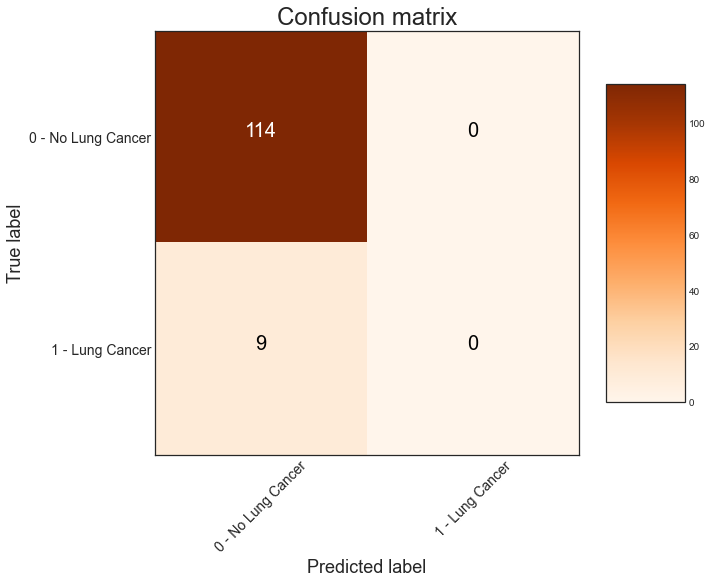

In [18]:
# Let us plot it
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes = ['0 - No Lung Cancer', '1 - Lung Cancer'])

As we can see, our classifier has not detect the minority class: none of the Lung-cancer obs has been correctly classified.

In fact, we see that the Test score is about 92%, which is the ratio of Lung-cancer cells. Let us now plot the ROC curve and then continue in improving our RF classifier.

In [20]:
# ROC curve plot

def evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs, col = 'tab:orange'):
    baseline = {}
    baseline['recall'] = recall_score(y_test, [1 for _ in range(len(y_test))])
    baseline['precision'] = precision_score(y_test, [1 for _ in range(len(y_test))])
    baseline['roc'] = 0.5
    
    results = {}
    results['recall'] = recall_score(y_test, y_pred)
    results['precision'] = precision_score(y_test, y_pred)
    results['roc'] = roc_auc_score(y_test, probs)
    
    train_results = {}
    train_results['recall'] = recall_score(y_train, train_predictions)
    train_results['precision'] = precision_score(y_train, train_predictions)
    train_results['roc'] = roc_auc_score(y_train, train_probs)
    
    for metric in ['recall', 'precision', 'roc']:
        print(f'{metric.capitalize()} Baseline: {round(baseline[metric], 2)} - Test: {round(results[metric], 2)}, Train: {round(train_results[metric], 2)}')

    # Calculate false positive rates and true positive rates
    base_fpr, base_tpr, _ = roc_curve(y_test, [1 for _ in range(len(y_test))])
    model_fpr, model_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize = (8, 6))
    plt.rcParams['font.size'] = 16

    # Plot both curves
    plt.plot(base_fpr, base_tpr, 'k--', label = 'Baseline')
    plt.plot(model_fpr, model_tpr, col, label = 'Model')
    plt.legend()
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate'); plt.title('ROC Curves')
    plt.show()

In [21]:
train_predictions = rf.predict(X_train)
train_probs = rf.predict_proba(X_train)[:, 1]
probs = rf.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_train, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

Train ROC AUC Score: 1.0
Test ROC AUC Score: 0.7183235867446394


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall Baseline: 1.0 - Test: 0.0, Train: 1.0
Precision Baseline: 0.07 - Test: 0.0, Train: 1.0
Roc Baseline: 0.5 - Test: 0.72, Train: 1.0


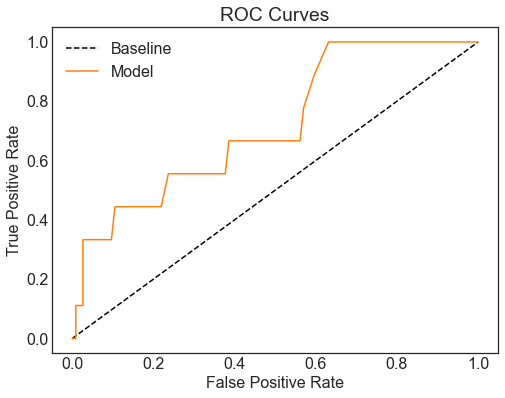

In [22]:
evaluate_model(y_pred, y_test, probs, y_train, train_predictions, train_probs)

As mentioned above, our RF classifier is not perfoming well on the minority class. So, let us use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'.

In [23]:
# n_estimators = [int(x) for x in np.linspace(start = 100, stop = 700, num = 50)]
# max_features = ['auto', 'log2']  # Number of features to consider at every split
# max_depth = [int(x) for x in np.linspace(2, 68, num = 11)]   # Maximum number of levels in tree
# max_depth.append(None)
# min_samples_split = [2, 5, 10]  # Minimum number of samples required to split a node
# min_samples_leaf = [4, 10, 25, 50]    # Minimum number of samples required at each leaf node

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'max_leaf_nodes': [None] + list(np.linspace(10, 50, 200).astype(int))}

# rf_cl = RandomForestClassifier(n_jobs = -1, class_weight = "balanced_subsample",
#                     bootstrap = True, oob_score = True)

# rf_random = RandomizedSearchCV(
#                 estimator = rf_cl,
#                 param_distributions = random_grid,
#                 cv = 5, n_iter = 2, # 50
#                 verbose = 1, random_state = 2311, 
#                 scoring = 'roc_auc')

In [24]:
# # Finally, fit the data
# rf_random.fit(X_train, y_train)

In [25]:
# rf_random.cv_results_

In [26]:
# rf_random.best_params_

In [40]:
sum(y_train)

55

In [75]:
rf = RandomForestClassifier(random_state = 42, n_jobs = -1,
                    n_estimators = 500, class_weight = "balanced_subsample",
                    min_samples_split = 60 , min_samples_leaf = 35,
                    bootstrap = True, oob_score = True)

In [76]:
rf.fit(X_train, y_train)
print('Training score: ', rf.score(X_train, y_train))
print('Test score: ', rf.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.9918367346938776
Test score:  0.926829268292683


The accuracy of the model is 92.7 %
Predicted 0 obs out of 9 True obs


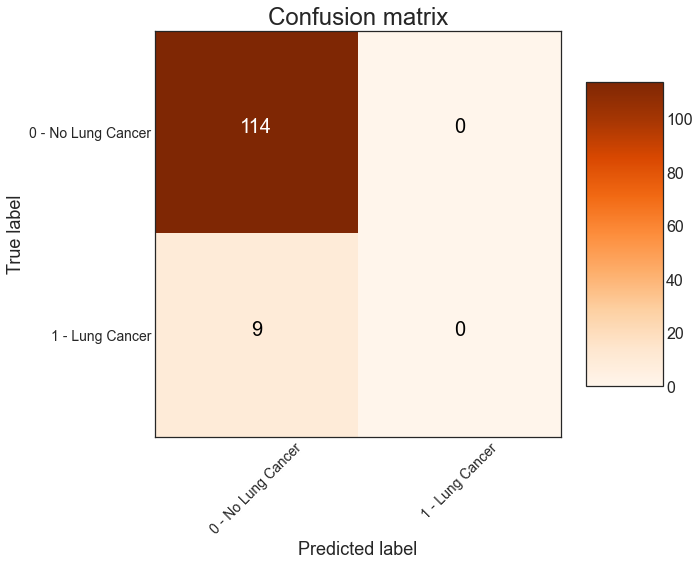

In [77]:
y_pred = rf.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

plot_confusion_matrix(confusion_matrix(y_test, y_pred),
                classes = ['0 - No Lung Cancer', '1 - Lung Cancer'])

Still no improvement. Let us see whether this moldel could bring a better classification

In [78]:
# 5-Fold Cross validation to validate the model
print(f'The mean cross validation score is: {np.mean(cross_val_score(rf, X_train, y_train, cv = 5))}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

The mean cross validation score is: 0.883673469387755


It seems we cannot build a better RF classifier with the current dataset, hence we take the adjusted traing dataset t for the minority class.

### 3. Random Forest for Balanced dataset

In [84]:
sm = SMOTE(random_state = 42, n_jobs = -1)
X_res, y_res = sm.fit_resample(X_train, y_train)

In [87]:
X_res.shape, y_res.shape, X_train.shape, y_train.shape

((870, 17393), (870,), (490, 17393), (490,))

In [88]:
sum(y_res)/len(y_res)

# Now, 50% of obs has labelled as lung cancer

435

In [106]:
rf_bal = RandomForestClassifier(random_state = 42, n_jobs = -1,
                    n_estimators = 500, class_weight = "balanced_subsample",
                    min_samples_split = 50, min_samples_leaf = 60,
                    bootstrap = True, oob_score = True)

rf_bal.fit(X_res, y_res)
print('Training score: ', rf_bal.score(X_res, y_res))
print('Test score: ', rf_bal.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.9655172413793104
Test score:  0.9186991869918699


The accuracy of the model is 91.9 %
Predicted 7 obs out of 9 True obs


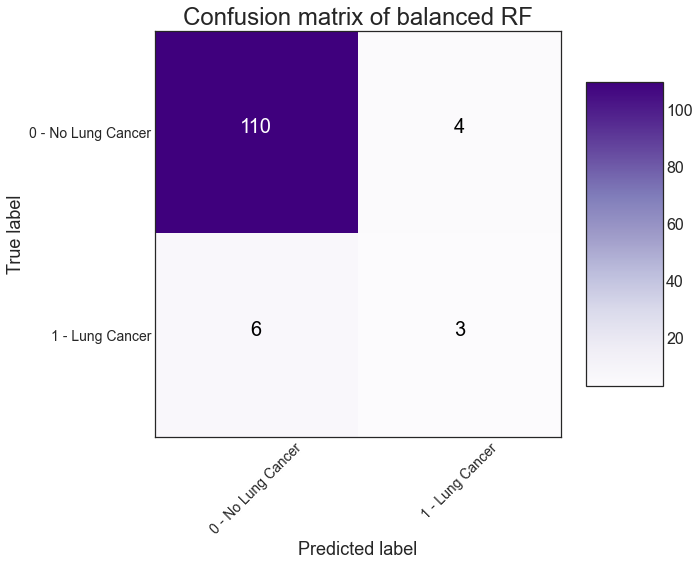

In [107]:
y_pred = rf_bal.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of balanced RF',
        cmap = plt.cm.Purples)

# Slightly better: it cannot predict correctly,
# but at least now it is able to detect the minority class

In [108]:
# Let us see the general performance of this model:
print(f'The mean cross validation score is: {np.mean(cross_val_score(rf_bal, X_res, y_res, cv = 5))}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

The mean cross validation score is: 0.9344827586206896


Train ROC AUC Score: 0.9940599815035011
Test ROC AUC Score: 0.702729044834308
Recall Baseline: 1.0 - Test: 0.33, Train: 0.93
Precision Baseline: 0.07 - Test: 0.43, Train: 1.0
Roc Baseline: 0.5 - Test: 0.7, Train: 0.99


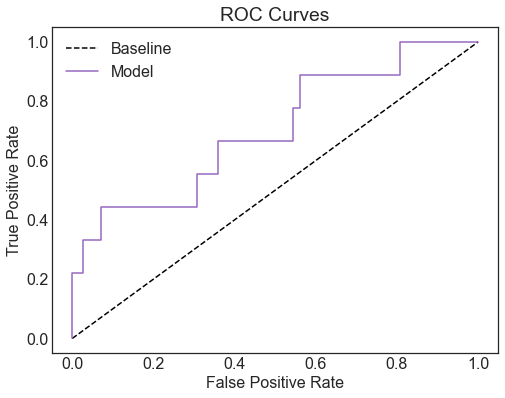

In [110]:
train_predictions = rf_bal.predict(X_res)
train_probs = rf_bal.predict_proba(X_res)[:, 1]
probs = rf_bal.predict_proba(X_test)[:, 1]

print(f'Train ROC AUC Score: {roc_auc_score(y_res, train_probs)}')
print(f'Test ROC AUC Score: {roc_auc_score(y_test, probs)}')

evaluate_model(y_pred, y_test, probs, y_res, train_predictions, train_probs, col = 'tab:purple')

### 4. Pruned Random Forest classifier
Balance dataset, weighted class.

Looking at the documentation of RandomForestClassifier, we see the attribute *ccp_alpha* (non-negative float, default = 0.0).

This is the complexity parameter used for Minimal Cost-Complexity Pruning. The subtree with the largest cost complexity that is smaller than ccp_alpha will be chosen. By default, no pruning is performed.

Let us try it to see if the situation gets better

In [113]:
# Let us try a 3-fold cv for finding the optimal alpha
ccp_alpha = [float(x) for x in np.linspace(start = 0.00005, stop = 0.001, num = 75)]
max_depth = [int(x) for x in np.linspace(5, 70, num = 15)]   # Maximum number of levels in tree
max_depth.append(None)

random_grid = {'ccp_alpha': ccp_alpha,
               'max_depth': max_depth}

# First create a base model:
rf_cl = RandomForestClassifier(n_estimators = 300, class_weight = "balanced_subsample",
                    min_samples_split = 50, min_samples_leaf = 60,
                    bootstrap = True, oob_score = True, n_jobs = -1)

# Then, use random grid to select the best model, based on the ROC_AUC score, hence scoring = 'roc_auc'
rf_random = RandomizedSearchCV(
                    estimator = rf_cl,
                    param_distributions = random_grid,
                    n_iter = 2, cv = 3,
                    verbose = 1, random_state = 2311,
                    scoring = 'roc_auc')

In [114]:
# Finally, fit the data
rf_random.fit(X_res, y_res)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                                    min_samples_leaf=60,
                                                    min_samples_split=50,
                                                    n_estimators=300, n_jobs=-1,
                                                    oob_score=True),
                   n_iter=2,
                   param_distributions={'ccp_alpha': [5e-05,
                                                      6.283783783783784e-05,
                                                      7.567567567567568e-05,
                                                      8.851351351351352e-05,
                                                      0.00010135135135135135,
                                                      0.00011418918918918919,
                                                      0.000127027027...
                                          

In [115]:
rf_random.best_params_

# Note that it chooses one of the two extremes of max_dept, thus we do not specify it

{'max_depth': 70, 'ccp_alpha': 0.0009486486486486486}

In [116]:
rf_pruned = RandomForestClassifier(random_state = 42, n_jobs = -1,
                    ccp_alpha = 0.00095, n_estimators = 500,
                    min_samples_split = 50, min_samples_leaf = 60,
                    class_weight = "balanced_subsample",
                    bootstrap = True, oob_score = True)

rf_pruned.fit(X_res, y_res)
print('Training score: ', rf_pruned.score(X_res, y_res))
print('Test score: ', rf_pruned.score(X_test, y_test))

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


Training score:  0.9655172413793104
Test score:  0.9186991869918699


The accuracy of the model is 91.9 %
Predicted 7 obs out of 9 True obs


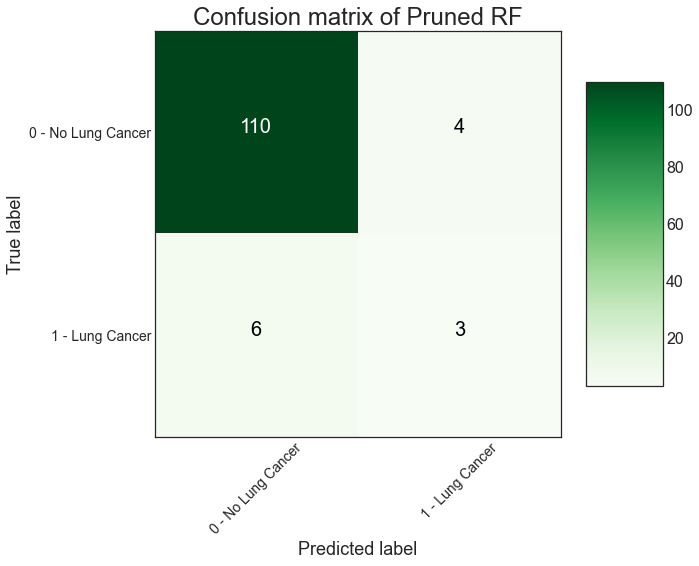

In [119]:
y_pred = rf_pruned.predict(X_test)
accuracy_score(y_test, y_pred)
print(f'The accuracy of the model is {round(accuracy_score(y_test, y_pred), 3)*100} %')

print(f'Predicted {y_pred.sum()} obs out of {y_test.sum()} True obs')

cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm,
        classes = ['0 - No Lung Cancer', '1 - Lung Cancer'],
        title = 'Confusion matrix of Pruned RF',
        cmap = plt.cm.Greens)

In [118]:
print(f'The mean cross validation score is: {np.mean(cross_val_score(rf_pruned, X_res, y_res, cv = 5))}')

C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
C:\Users\user\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:441: 

The mean cross validation score is: 0.9344827586206896


Same accuracy as the RF classifier for the blanced dataset.

### 5. Feature Importance
We have tried different models and non of them is good enough in classifying Lung -cancer cells. Therefore, it does not make any sense to persue with this classification and use it to select the most important features.